#FA PROJECT- 1 

015049- KHUSHBU MALHOTRA 

# Google Stock Price Prediction 

The art of forecasting stock prices has been a difficult task for many of the researchers and analysts. In fact, investors are highly interested in the research area of stock price prediction. For a good and successful investment, many investors are keen on knowing the future situation of the stock market. Good and effective prediction systems for the stock market help traders, investors, and analyst by providing supportive information like the future direction of the stock market. In this work, we present a recurrent neural network (RNN) and Long Short-Term Memory (LSTM) approach to predict stock market indices.

In [ ]:
!pip install keras-tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


     |████████████████████████████████| 98 kB 4.6 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
df_train = pd.read_csv('/content/Google_Stock_Price_Train.csv')


In [ ]:
df_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [ ]:
df_train.shape

(1258, 6)

In [ ]:
df_train.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [ ]:
df_train.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [ ]:
df_train['Date']=pd.to_datetime(df_train['Date'])

In [ ]:
print("Minimum date value : {}".format(df_train['Date'].min()))
print("Maximum date value : {}".format(df_train['Date'].max()))

Minimum date value : 2012-01-03 00:00:00
Maximum date value : 2016-12-30 00:00:00


In [ ]:
df_closing = df_train['Close'].apply(lambda x : x.replace(',', '')).astype('float')
df_closing.head()

0    663.59
1    666.45
2    657.21
3    648.24
4    620.76
Name: Close, dtype: float64

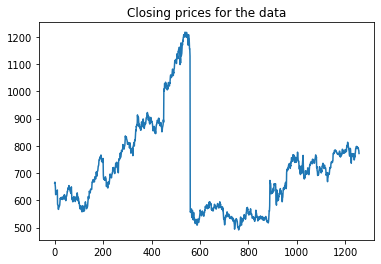

In [ ]:
plt.plot(df_closing.values);
plt.title("Closing prices for the data");

In [ ]:
# Scaling The Data
scaler=MinMaxScaler(feature_range=(0,1))
df_closing=scaler.fit_transform(np.array(df_closing).reshape(-1,1))

In [ ]:
def create_dataset(dataset, time_step=1):
    x_data, y_data = [], []
    
    for i in range(len(dataset)-time_step-1):
        x_data.append(dataset[i:(i+time_step), 0])
        y_data.append(dataset[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

In [ ]:
# Preparing train and test data

training_size=int(len(df_closing)*0.65)
test_size=len(df_closing)-training_size
train_data,test_data=df_closing[0:training_size,:],df_closing[training_size:len(df_closing),:1]

In [ ]:
#Taking data for past 100 days for next prediction
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

<a id="4"></a>

# <p style="background-color:#DC143C;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Modelling With LSTM And Tuning The Hyperparameters</p>

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(layers.LSTM(units = hp.Choice('layer1_units', [10,20,30,40,50,60,70,80,90,100]),return_sequences=True,input_shape=(100,1)))
    
    for i in range(hp.Int('num_layers', 2, 15)):                        
        model.add(layers.LSTM(units =  hp.Int('units' + str(i), min_value=10, max_value=150, step=10), return_sequences=True))
    
    model.add(LSTM(units = hp.Choice('last_lstm_units', [50, 100, 150])))
    model.add(Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5, 0.6, 0.7])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam' )
    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials= 5,
    executions_per_trial=3,
    directory='project', project_name = 'Stacked_LSTM_Stock_Prediction')

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs= 5,
             validation_data=(X_test, ytest))

Trial 5 Complete [00h 05m 04s]
val_loss: 0.0027984684177984795

Best val_loss So Far: 0.0027984684177984795
Total elapsed time: 00h 24m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()


Results summary
Results in project/Stacked_LSTM_Stock_Prediction
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layer1_units: 40
num_layers: 8
units0: 60
units1: 120
last_lstm_units: 100
rate: 0.5
units2: 30
units3: 150
units4: 70
units5: 40
units6: 20
units7: 90
units8: 110
units9: 50
units10: 60
units11: 60
units12: 130
units13: 60
Score: 0.0027984684177984795
Trial summary
Hyperparameters:
layer1_units: 20
num_layers: 12
units0: 110
units1: 50
last_lstm_units: 150
rate: 0.6
units2: 20
units3: 30
units4: 130
units5: 80
units6: 70
units7: 90
units8: 110
units9: 60
units10: 80
units11: 130
Score: 0.0034568350141247115
Trial summary
Hyperparameters:
layer1_units: 60
num_layers: 8
units0: 80
units1: 90
last_lstm_units: 100
rate: 0.4
units2: 10
units3: 10
units4: 10
units5: 10
units6: 10
units7: 10
Score: 0.0036224888948102794
Trial summary
Hyperparameters:
layer1_units: 70
num_layers: 12
units0: 110
units1: 150
last_lstm_units: 100
rate:

In [ ]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 40)           6720      
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           24240     
                                                                 
 lstm_2 (LSTM)               (None, 100, 120)          86880     
                                                                 
 lstm_3 (LSTM)               (None, 100, 30)           18120     
                                                                 
 lstm_4 (LSTM)               (None, 100, 150)          108600    
                                                                 
 lstm_5 (LSTM)               (None, 100, 70)           61880     
                                                                 
 lstm_6 (LSTM)               (None, 100, 40)           1

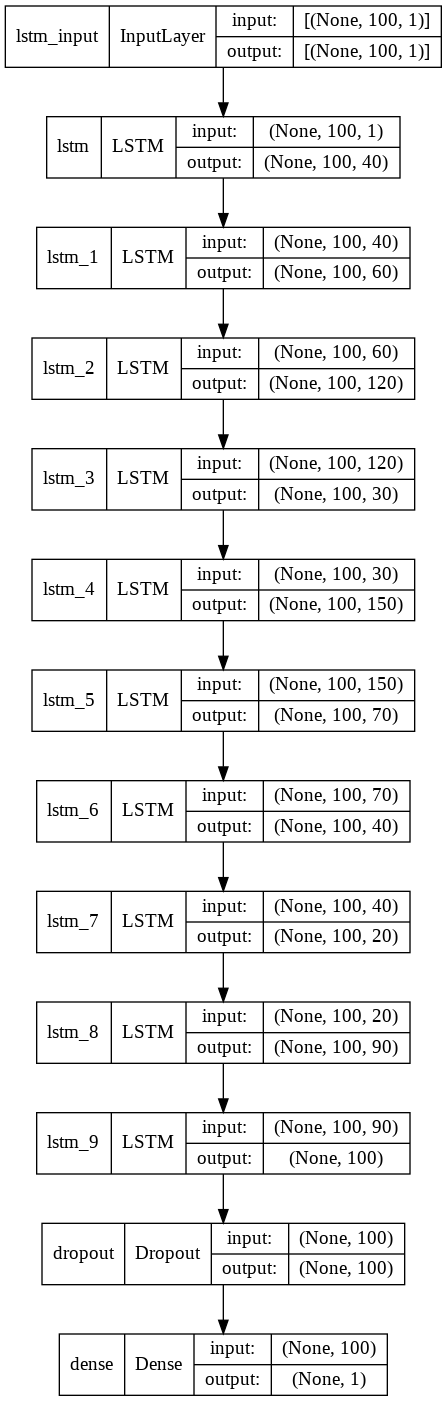

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes= True)

In [ ]:
model_history = model.fit(X_train,y_train, epochs=50, validation_data=(X_test,ytest))

Epoch 1/50
23/23 [==============================] - 32s 596ms/step - loss: 0.0255 - val_loss: 0.0039
Epoch 2/50
23/23 [==============================] - 8s 334ms/step - loss: 0.0187 - val_loss: 0.0026
Epoch 3/50
23/23 [==============================] - 8s 332ms/step - loss: 0.0243 - val_loss: 0.0024
Epoch 4/50
23/23 [==============================] - 8s 332ms/step - loss: 0.0199 - val_loss: 0.0022
Epoch 5/50
23/23 [==============================] - 8s 330ms/step - loss: 0.0137 - val_loss: 0.0022
Epoch 6/50
23/23 [==============================] - 8s 333ms/step - loss: 0.0149 - val_loss: 0.0060
Epoch 7/50
23/23 [==============================] - 8s 335ms/step - loss: 0.0171 - val_loss: 0.0033
Epoch 8/50
23/23 [==============================] - 8s 334ms/step - loss: 0.0123 - val_loss: 0.0020
Epoch 9/50
23/23 [==============================] - 8s 334ms/step - loss: 0.0099 - val_loss: 0.0021
Epoch 10/50
23/23 [==============================] - 8s 334ms/step - loss: 0.0100 - val_loss: 0.003

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

Text(0.5, 1.0, 'Train Vs Test predictions')

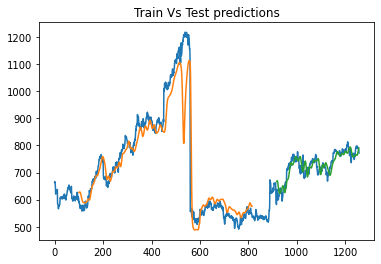

In [ ]:
look_back=100
trainPredictPlot = np.empty_like(df_closing)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df_closing)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_closing)-1, :] = test_predict

plt.plot(scaler.inverse_transform(df_closing))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Train Vs Test predictions');
plt.show()



# <p style="background-color:#DC143C;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Predictions For Next 10 Days</p>

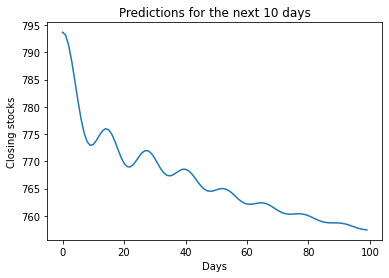

In [ ]:
future_predictions = test_data.copy()
for i in range(100):
    new_prediction = model.predict(((future_predictions[341+i:])).reshape(1,100,1))
    future_predictions = np.append(future_predictions, new_prediction)
    
plt.plot(scaler.inverse_transform(future_predictions[441:].reshape(-1, 1)));
plt.title('Predictions for the next 10 days');
plt.xlabel('Days');
plt.ylabel('Closing stocks');


<a id="5"></a>

# <p style="background-color:#DC143C;font-family:newtimeroman;color:#000000;font-size:150%;text-align:center;border-radius:40px 40px;">Results And Conclusion</p>

In [ ]:
print("Train RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test RMSE: ", math.sqrt(mean_squared_error(ytest,test_predict)))


Train RMSE:  745.9544153825539
Test RMSE:  729.0477361069453


# The model is performing pretty well, train and test MSE are close.